In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [194]:
df = pd.read_csv("sonar.all-data", names=list(range(1,61)) + ["target"], index_col=False)

In [195]:
df["target"] = df["target"].map({"R":0, "M":1})

In [196]:
from sklearn.model_selection import StratifiedShuffleSplit

In [197]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=10)
train_ind, test_ind = next(strat_split.split(df.drop(labels=["target"], axis=1), df["target"]))
X_train = df.iloc[train_ind].drop(labels=['target'], axis=1)
y_train = df.iloc[train_ind]["target"]
X_test = df.iloc[test_ind].drop(labels=['target'], axis=1)
y_test = df.iloc[test_ind]["target"]
split_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=10)
train_ind, valid_ind = next(split_valid.split(X_train, y_train))
X_valid = X_train.iloc[valid_ind]
X_train = X_train.iloc[train_ind]
y_valid = y_train.iloc[valid_ind]
y_train = y_train.iloc[train_ind]

In [198]:
from sklearn.preprocessing import StandardScaler

In [199]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_valid_std = scaler.transform((X_valid))

In [200]:
def print_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(tn, fn)
    print(fp, tp)

## Model

In [201]:
import tensorflow as tf
from tensorflow import keras
import tensorboard

In [202]:
deep_model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_train_std.shape[1]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
deep_model.save_weights(filepath="./init_weights.h5")

In [203]:
history = {}
n_epochs = 70

## SGD

In [204]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.SGD(lr=0.001), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['sgd'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 0s 40ms/step - loss: 0.6920 - accuracy: 0.5152 - val_loss: 0.6432 - val_accuracy: 0.5769
Epoch 2/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6787 - accuracy: 0.5334 - val_loss: 0.6419 - val_accuracy: 0.5769
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6816 - accuracy: 0.5352 - val_loss: 0.6408 - val_accuracy: 0.5769
Epoch 4/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6864 - accuracy: 0.5202 - val_loss: 0.6395 - val_accuracy: 0.5769
Epoch 5/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6865 - accuracy: 0.4918 - val_loss: 0.6380 - val_accuracy: 0.5769
Epoch 6/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6767 - accuracy: 0.5167 - val_loss: 0.6366 - val_accuracy: 0.6154

In [205]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5250


[0.6776086688041687, 0.5249999761581421]

In [206]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [207]:
print_confusion(y_test, y_preds_deep)

11 11
8 10


In [208]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        19
           1       0.56      0.48      0.51        21

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



## SGD with momentum

In [209]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.SGD(lr=0.001, momentum=0.9), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['momentum'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 0s 31ms/step - loss: 0.6986 - accuracy: 0.4768 - val_loss: 0.6408 - val_accuracy: 0.5769
Epoch 2/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.4929 - val_loss: 0.6323 - val_accuracy: 0.6538
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6747 - accuracy: 0.5175 - val_loss: 0.6248 - val_accuracy: 0.7308
Epoch 4/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6709 - accuracy: 0.5429 - val_loss: 0.6175 - val_accuracy: 0.7692
Epoch 5/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6602 - accuracy: 0.5890 - val_loss: 0.6108 - val_accuracy: 0.8077
Epoch 6/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6449 - accuracy: 0.6271 - val_loss: 0.6053 - val_accuracy: 0.8846

In [210]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 0.4531 - accuracy: 0.8000


[0.4531422555446625, 0.800000011920929]

In [211]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [212]:
print_confusion(y_test, y_preds_deep)

15 4
4 17


In [213]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.81      0.81      0.81        21

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



## Nestrov Accelerated Gradient

In [214]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['Nestrov'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 0s 31ms/step - loss: 0.6970 - accuracy: 0.4931 - val_loss: 0.6403 - val_accuracy: 0.5769
Epoch 2/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6959 - accuracy: 0.4706 - val_loss: 0.6310 - val_accuracy: 0.6538
Epoch 3/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6723 - accuracy: 0.5058 - val_loss: 0.6229 - val_accuracy: 0.7308
Epoch 4/70
5/5 [==============================] - 0s 9ms/step - loss: 0.6720 - accuracy: 0.5316 - val_loss: 0.6164 - val_accuracy: 0.7692
Epoch 5/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6479 - accuracy: 0.6183 - val_loss: 0.6100 - val_accuracy: 0.8077
Epoch 6/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6607 - accuracy: 0.5739 - val_loss: 0.6051 - val_accuracy: 0.8462

In [215]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 0.4471 - accuracy: 0.8000


[0.447148859500885, 0.800000011920929]

In [216]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [217]:
print_confusion(y_test, y_preds_deep)

14 3
5 18


In [218]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.78      0.86      0.82        21

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



## AdaGrad

In [219]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.Adagrad(lr=0.001), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['adagrad'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 0s 33ms/step - loss: 0.6706 - accuracy: 0.5703 - val_loss: 0.6398 - val_accuracy: 0.5769
Epoch 2/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.5057 - val_loss: 0.6367 - val_accuracy: 0.6154
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.4457 - val_loss: 0.6331 - val_accuracy: 0.6154
Epoch 4/70
5/5 [==============================] - 0s 10ms/step - loss: 0.6890 - accuracy: 0.4867 - val_loss: 0.6299 - val_accuracy: 0.6538
Epoch 5/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6659 - accuracy: 0.5082 - val_loss: 0.6273 - val_accuracy: 0.6538
Epoch 6/70
5/5 [==============================] - 0s 8ms/step - loss: 0.6707 - accuracy: 0.5012 - val_loss: 0.6260 - val_accuracy: 0.7308

In [220]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 0.6104 - accuracy: 0.6250


[0.6104063987731934, 0.625]

In [221]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [222]:
print_confusion(y_test, y_preds_deep)

12 8
7 13


In [223]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        19
           1       0.65      0.62      0.63        21

    accuracy                           0.62        40
   macro avg       0.62      0.63      0.62        40
weighted avg       0.63      0.62      0.63        40



## RMSProp

In [224]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.RMSprop(momentum=0.9, rho=0.9, lr=0.001), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['rmsprop'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 0s 31ms/step - loss: 0.6956 - accuracy: 0.5322 - val_loss: 0.6385 - val_accuracy: 0.5385
Epoch 2/70
5/5 [==============================] - 0s 7ms/step - loss: 0.3469 - accuracy: 0.8137 - val_loss: 0.3890 - val_accuracy: 0.8462
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.1796 - accuracy: 0.9041 - val_loss: 0.5011 - val_accuracy: 0.7692
Epoch 4/70
5/5 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.9737 - val_loss: 0.2332 - val_accuracy: 0.9231
Epoch 5/70
5/5 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.9840 - val_loss: 0.8685 - val_accuracy: 0.8077
Epoch 6/70
5/5 [==============================] - 0s 8ms/step - loss: 0.0107 - accuracy: 0.9920 - val_loss: 0.7424 - val_accuracy: 0.8846

In [225]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 1.6169 - accuracy: 0.8500


[1.616886854171753, 0.8500000238418579]

In [226]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [227]:
print_confusion(y_test, y_preds_deep)

15 2
4 19


In [228]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.83      0.90      0.86        21

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



## Adam

In [229]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, lr=0.001), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['adam'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 0s 33ms/step - loss: 0.6748 - accuracy: 0.5190 - val_loss: 0.5513 - val_accuracy: 0.8462
Epoch 2/70
5/5 [==============================] - 0s 8ms/step - loss: 0.5353 - accuracy: 0.8149 - val_loss: 0.4872 - val_accuracy: 0.9231
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.4548 - accuracy: 0.8497 - val_loss: 0.4537 - val_accuracy: 0.8462
Epoch 4/70
5/5 [==============================] - 0s 8ms/step - loss: 0.3783 - accuracy: 0.9050 - val_loss: 0.4179 - val_accuracy: 0.8077
Epoch 5/70
5/5 [==============================] - 0s 8ms/step - loss: 0.2828 - accuracy: 0.9407 - val_loss: 0.3841 - val_accuracy: 0.8077
Epoch 6/70
5/5 [==============================] - 0s 7ms/step - loss: 0.2204 - accuracy: 0.9506 - val_loss: 0.3460 - val_accuracy: 0.8462

In [230]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 0.6312 - accuracy: 0.9000


[0.6311606764793396, 0.8999999761581421]

In [231]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [232]:
print_confusion(y_test, y_preds_deep)

16 1
3 20


In [233]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.87      0.95      0.91        21

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



## Nadam

In [234]:
deep_model.load_weights("./init_weights.h5")
deep_model.compile(keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999, lr=0.001), loss = keras.losses.binary_crossentropy, metrics=["accuracy"])
history['Nadam'] = deep_model.fit(X_train_std, y_train, epochs=n_epochs, validation_data=(X_valid_std, y_valid))

Epoch 1/70
5/5 [==============================] - 1s 33ms/step - loss: 0.6795 - accuracy: 0.5487 - val_loss: 0.5745 - val_accuracy: 0.8462
Epoch 2/70
5/5 [==============================] - 0s 7ms/step - loss: 0.5785 - accuracy: 0.7011 - val_loss: 0.5184 - val_accuracy: 0.9231
Epoch 3/70
5/5 [==============================] - 0s 7ms/step - loss: 0.5064 - accuracy: 0.8080 - val_loss: 0.4679 - val_accuracy: 0.8846
Epoch 4/70
5/5 [==============================] - 0s 9ms/step - loss: 0.4159 - accuracy: 0.8859 - val_loss: 0.4197 - val_accuracy: 0.9231
Epoch 5/70
5/5 [==============================] - 0s 8ms/step - loss: 0.3576 - accuracy: 0.9073 - val_loss: 0.4024 - val_accuracy: 0.7692
Epoch 6/70
5/5 [==============================] - 0s 8ms/step - loss: 0.2631 - accuracy: 0.9514 - val_loss: 0.3687 - val_accuracy: 0.8462

In [235]:
deep_model.evaluate(X_test_std, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 0.6008 - accuracy: 0.9000


[0.6007863283157349, 0.8999999761581421]

In [236]:
y_preds_deep = deep_model.predict_classes(X_test_std)

/home/nimahsn/anaconda3/envs/ml-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [237]:
print_confusion(y_test, y_preds_deep)

16 1
3 20


In [238]:
print(classification_report(y_test, y_preds_deep))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.87      0.95      0.91        21

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



## Plots

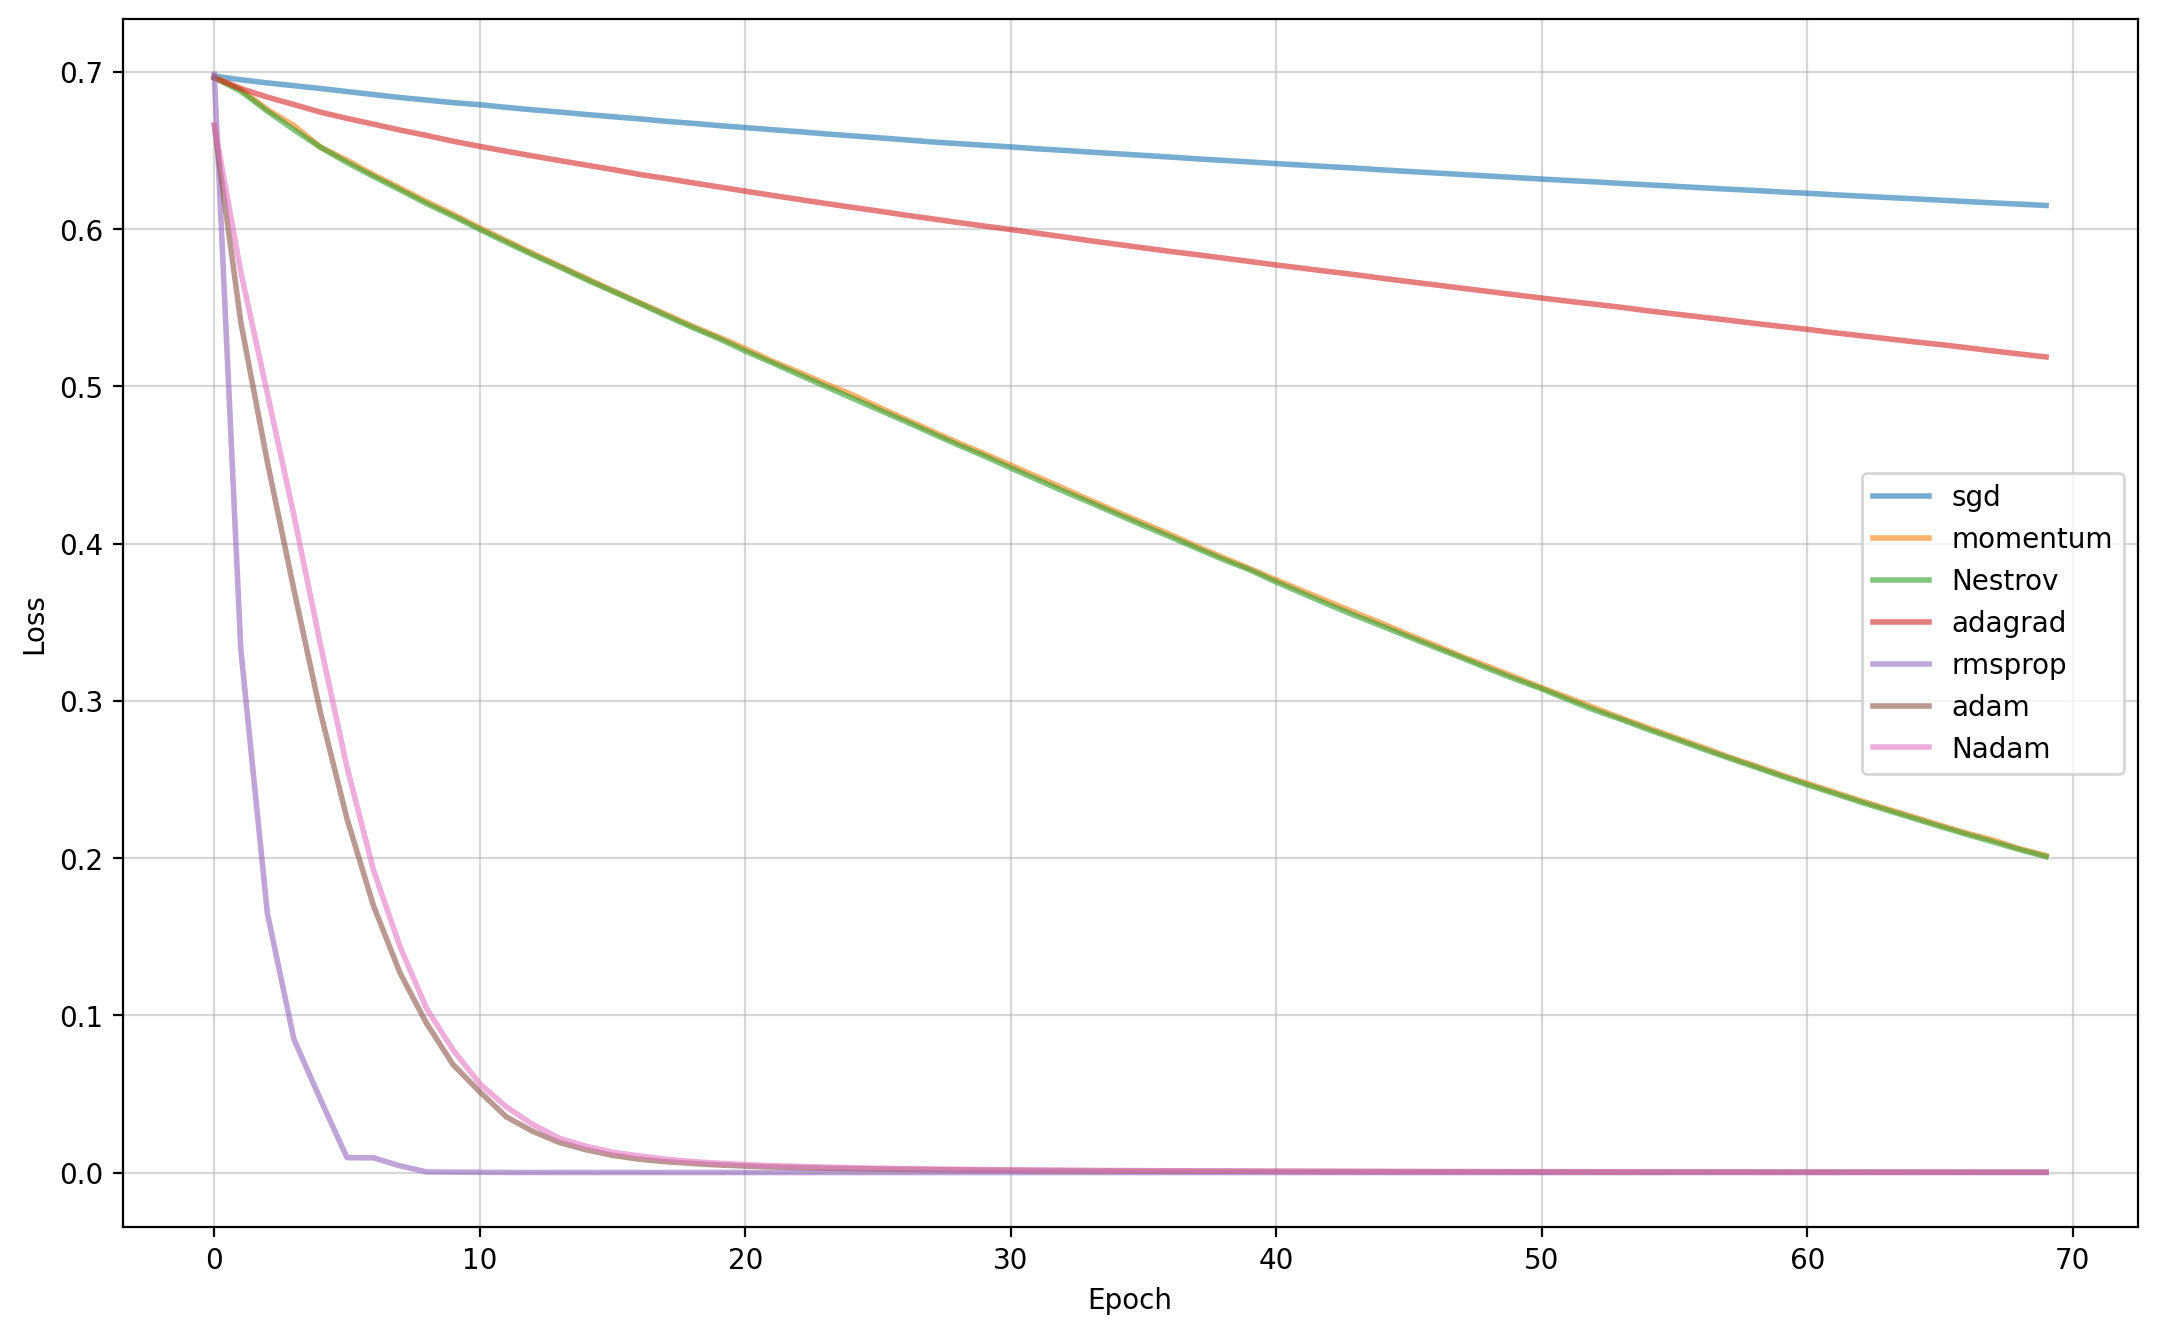

In [239]:
plt.figure(figsize=(13,8), dpi=200)
for key in history.keys():
    plt.plot(history[key].history["loss"], lw=2, label=key, alpha=0.6)
plt.legend()
plt.grid(True, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./loss.png', dpi=200)

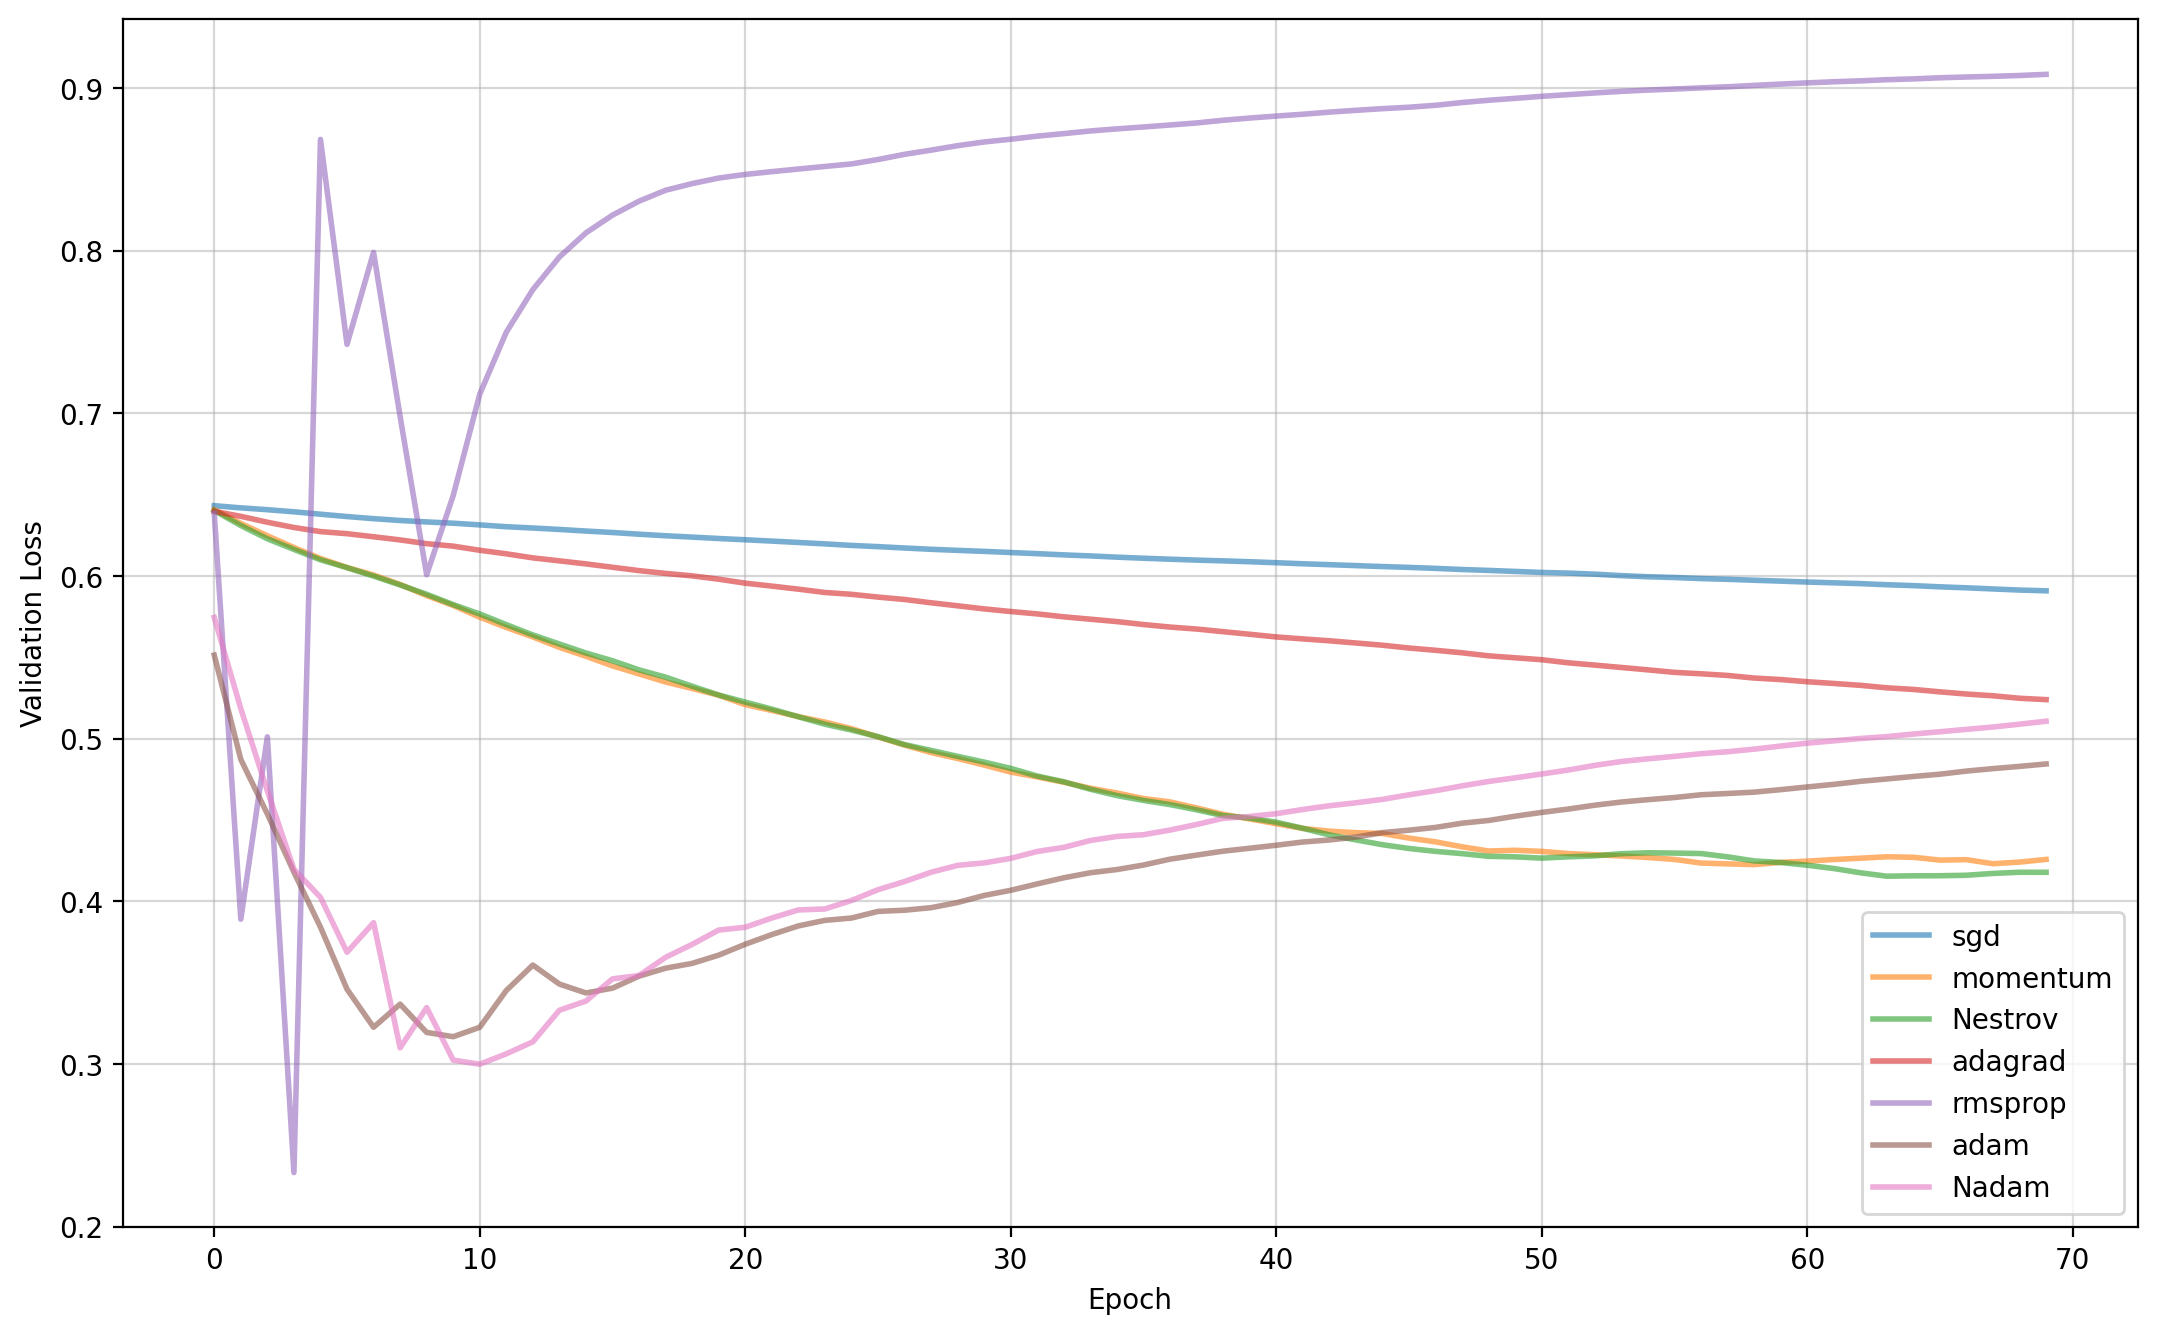

In [240]:
plt.figure(figsize=(13,8), dpi=200)
for key in history.keys():
    plt.plot(history[key].history["val_loss"], lw=2, label=key, alpha=0.6)
plt.legend()
plt.grid(True, alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.savefig('./valloss.png', dpi=200)